I am heavily referring to https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8 for this notebook.
Using KerasCNN

In [9]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import platform
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

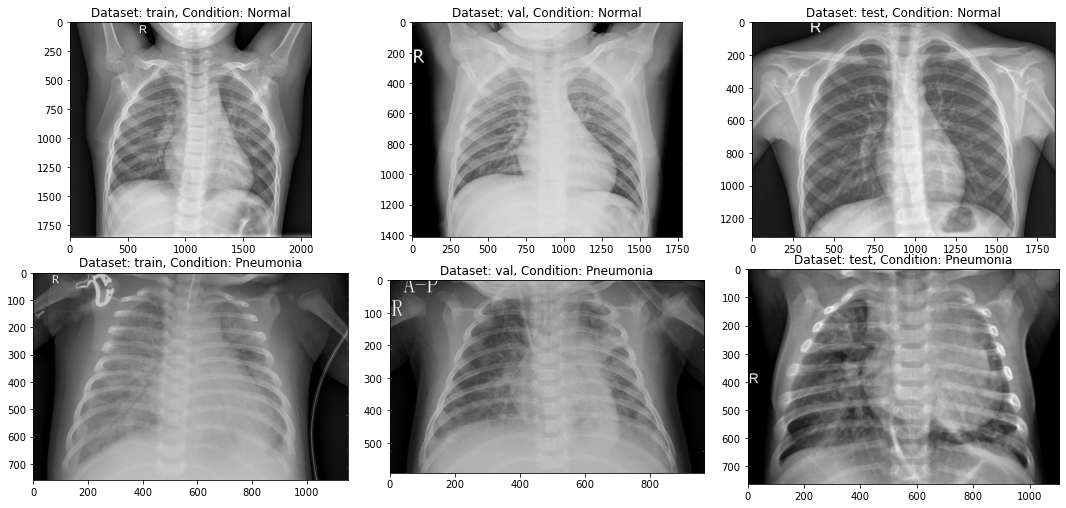

In [32]:
### System Settings ###
pdiv = "/" if platform.system() == "Windows" else "\\"

### Visualising the Dataset ###
fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()
path = ".{}chest_xray{}".format(pdiv,pdiv)


## We Grayscale the images to better spot the differences ###
for i, _set in enumerate(['train', 'val', 'test']):
    ax[i].imshow(plt.imread(path+_set+pdiv+'NORMAL'+pdiv+os.listdir(path+_set+pdiv+'NORMAL')[0]), cmap='gray')
    ax[i].set_title('Dataset: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(path+_set+pdiv+'PNEUMONIA'+pdiv+os.listdir(path+_set+pdiv+'PNEUMONIA')[0]), cmap='gray')
    ax[i+3].set_title('Dataset: {}, Condition: Pneumonia'.format(_set))

It is evident that the differences between a "Normal" and a "Pneumonia" chest-X-ray are highly similar, with the differences being very difficult to identify. A professional trained Radiologist takes anywhere from 15 minutes to an hour to identify and classify the patients into either "Normal" or "Pneumonia"

In [37]:
### Inspecting the Dataset ###

for _dataset in ['train', 'val', 'test']:
    num_normal = len(os.listdir(path + _dataset + '/NORMAL'))
    num_pneu = len(os.listdir(path + _dataset + '/PNEUMONIA'))
    print('Set: {}, No. of Normal Images: {}, No. of Pneumonia images: {}'.format(_dataset, num_normal, num_pneu))

Set: train, No. of Normal Images: 1341, No. of Pneumonia images: 3875
Set: val, No. of Normal Images: 8, No. of Pneumonia images: 8
Set: test, No. of Normal Images: 234, No. of Pneumonia images: 390


We observe that the number of Normal images are far fewer than the number of Pneumonia images in the training set, as well as the number of images in the validation set is very low. This means that we have to create our own data, or data augmentation to produce more training data.

In [ ]:
### Data Augmentation/Generation ##
def data_gen(img_height, img_width, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, vertical_flip=True, rotation_range=20, brightness_range=(1.1,1.3))
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        directory = path+'train',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    val_gen = val_datagen.flow_from_directory(
        directory = path+'val',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    test_gen = test_datagen.flow_from_directory(
        directory = path+'test',
        target_size = (img_height, img_width),
        class_mode = 'binary',
        batch_size = batch_size,
        shuffle = True
    )
    
    #TODO finish up image Generation
    
def process_data(img_dims, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    # I will be making predictions off of the test set in one batch size
    # This is useful to be able to get the confusion matrix
    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
### Building the Model ###

#TODO Build the Keras CNN

To check how good our trained model is, we will check the Recall and Precision of our model
$Recall = \frac{True Positives}{True Positives + False Negatives}$

$Precision = \frac{True Positives}{True Positives + False Positives}$

For predicting pneumonia, we should aim to maximise Recall as the complications caused by incorrectly classifying a pneumonia case as a normal case is much more deadly than a normal case being classified as a pneumonia case. With the former being possibly deadly to the incorrectly labelled individual while the latter will soon be spotted by medical staff and corrected.